# IMPORTS AND GENERAL FUNCTIONS

In [18]:
# default_exp preprocessing
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from modules import preprocessing as prep
import os
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
path_base = "./local/data/"

# EXTRACTING DENGUE DATA FROM SIVIGILA FILE YEARS 2007 to 2020

In [20]:
df_calendar = prep.get_sivigila_calendar()
df_calendar_weekly = prep.get_sivigila_calendar().drop_duplicates(subset=["ANO","SEMANA"])
df_dengue_2007_2018 = prep.read_all_rutinarias()
df_dengue_2007_2018 = prep.re_assert_cod_datatypes(df_dengue_2007_2018)
df_dengue_2007_2018.head()

Doing year  2007
Doing year  2008


In [ ]:
os.makedirs(path_base + "prepared_dengue", exist_ok=True)
df_dengue_2007_2018.to_csv(path_base+"prepared_dengue/df_dengue_07_18.csv")

## YEARS 2019-2020

In [6]:
years = [ 2019, 2020, 2021]

filenames_2019_2020 = ["rutinaria_2019.xlsx","rutinaria_2020.xlsx", "rutinaria_2021.xlsx"]
dfs_2019_2020 = []
starting_column_xlsx = {2019:0, 2020:0, 2021:0}

#years = [2021]
#filenames_2019_2020 = ["rutinaria_2021.xlsx"]

In [7]:
for i, year in enumerate(years):
    print("Doing year",year,"...")
    wb = pd.read_excel(path_base+"src_general/rutinarias_dengue/"+filenames_2019_2020[i], sheet_name=1, engine="openpyxl")
    wb = wb.iloc[2:,starting_column_xlsx[year]:]
    for col in wb.columns[3:4]:
        if np.sum(wb.loc[:,col].str.contains("CALI")):
            mun_col = col
            break       
    lista_municipios = list(wb.loc[:, col].unique())
    try:
        lista_municipios = lista_municipios[lista_municipios.index("* ANTIOQUIA. MUNICIPIO DESCONOCIDO"):]
    except:
        lista_municipios = lista_municipios[lista_municipios.index("MEDELLIN"):]
    
    if year != 2021:
        lista_municipios = [ (lista_municipios[i],lista_municipios[i+1]) for i in range(0,len(lista_municipios),2) ]
    else:
        lista_municipios.pop(1)
        lista_municipios = [(lista_municipios[i],lista_municipios[i+1]) for i in range(0,len(lista_municipios)-1)]

    dfs = []
    for i,mun in enumerate(lista_municipios):
        index1_mun = prep.get_index_from_col_and_string(wb, mun_col, mun[0])
        index2_mun = prep.get_index_from_col_and_string(wb, mun_col, mun[1])
        if year == 2021:
            index2_mun = index2_mun - 2
        subset_mun = wb.loc[index1_mun:index2_mun-1, :]
        subset_mun = subset_mun.iloc[:,:-1]
        if not (subset_mun.iloc[0,0] is np.nan):
            cod_depto = int(subset_mun.iloc[0,0])
            if cod_depto in [48, 9, 14]:
                cod_depto-=1
        
        cod_municipio = str(cod_depto).zfill(2) + str(subset_mun.iloc[0,2]).zfill(3)
        den_mort_series = prep.get_time_series_from_municipio_subset(subset_mun, 4,"580", year)
        dengue_series = prep.get_time_series_from_municipio_subset(subset_mun, 4 ,"210", year)
        den_grave_series = prep.get_time_series_from_municipio_subset(subset_mun, 4,"220", year)
        dengue_series = [year, cod_depto, cod_municipio] + dengue_series
        den_mort_series = [year, cod_depto, cod_municipio] + den_mort_series
        den_grave_series =  [year, cod_depto, cod_municipio] + den_grave_series
        df_dengue = prep.dataframe_from_dengue_series(dengue_series, value_name = "DENGUE", year = year)
        df_dengue_grave = prep.dataframe_from_dengue_series(den_grave_series, value_name = "DENGUE GRAVE",year = year)
        df_den_mort = prep.dataframe_from_dengue_series(den_mort_series, value_name = "MORTALIDAD POR DENGUE",year = year)
        df_dengue["DENGUE GRAVE"] = df_dengue_grave["DENGUE GRAVE"]
        df_dengue["MORTALIDAD POR DENGUE"]  = df_den_mort["MORTALIDAD POR DENGUE"]
        dfs.append(df_dengue)

        

    df_dengue_20XX = pd.concat(dfs, axis = 0)
    df_dengue_20XX = prep.re_assert_cod_datatypes(df_dengue_20XX)
    del dfs
    dfs_2019_2020.append(df_dengue_20XX)

Doing year 2019 ...
Doing year 2020 ...
Doing year 2021 ...


In [8]:
dfs_2019_2020[-3]["DENGUE"].sum()

117419

dfs_2019_2020

In [9]:
df_dengue_2007_2020 = pd.concat([df_dengue_2007_2018]+dfs_2019_2020)
df_dengue_2007_2020 = prep.re_assert_cod_datatypes(df_dengue_2007_2020)
df_dengue_2007_2020["COD_MUNICIPIO"] = df_dengue_2007_2020["COD_MUNICIPIO"].apply(lambda x: str(x).zfill(5))
df_dengue_2007_2020

,ANO,COD_DPTO,COD_MUNICIPIO,SEMANA,DENGUE,DENGUE GRAVE,MORTALIDAD POR DENGUE
0,2007,05,05000,02,1,<NA>,<NA>
1,2007,05,05000,03,<NA>,2,<NA>
2,2007,05,05000,04,4,<NA>,<NA>
3,2007,05,05000,05,11,<NA>,<NA>
4,2007,05,05000,06,4,2,<NA>
...,...,...,...,...,...,...,...
47,2021,99,99624,48,0,0,0
48,2021,99,99624,49,0,0,0
49,2021,99,99624,50,0,0,0
50,2021,99,99624,51,0,0,0


In [10]:
df_cities = pd.read_csv(path_base+"src_general/departments.csv")[["COD_DPTO","COD_MUNICIPIO"]]
#Removes unknown or foreign dengue cases
df_cities = df_cities[~df_cities["COD_DPTO"].isin([0,1])]
#df_cities = df_cities.apply(prep.get_composite_city_code, axis = 1)
df_cities.head(1)

,COD_DPTO,COD_MUNICIPIO
0,91,91000


In [11]:
df_weeks_cities = prep.combine_cities_and_weeks(df_calendar_weekly, df_cities)
df_weeks_cities["COD_MUNICIPIO"] = df_weeks_cities["COD_MUNICIPIO"].apply(lambda x: str(x).zfill(5))
df_dengue_2007_2020["COD_MUNICIPIO"] = df_dengue_2007_2020["COD_MUNICIPIO"].apply(lambda x: str(x).zfill(5))
df_weeks_cities["SEMANA"] = df_weeks_cities["SEMANA"].apply(lambda x: str(x).zfill(2))
df_dengue_2007_2020["SEMANA"] = df_dengue_2007_2020["SEMANA"].apply(lambda x: str(x).zfill(2))
df_weeks_cities["ANO"] = df_weeks_cities["ANO"].apply(lambda x: str(x).zfill(4))
df_dengue_2007_2020["ANO"] = df_dengue_2007_2020["ANO"].apply(lambda x: str(x).zfill(4))
df_weeks_cities = prep.re_assert_cod_datatypes(df_weeks_cities)
df_weeks_cities.tail(5)

,ANO,SEMANA,COD_MUNICIPIO,COD_DPTO
FECHA,,,,
2021-12-05,2021,49,99624,99
2021-12-12,2021,50,99624,99
2021-12-19,2021,51,99624,99
2021-12-26,2021,52,99624,99
2022-01-02,2022,01,99624,99


In [12]:
df_dengue_city_week = prep.combine_cities_weeks_and_dengue(df_weeks_cities, df_dengue_2007_2020)
df_dengue_city_week = df_dengue_city_week.fillna(0)
df_dengue_city_week["ANO"] = df_dengue_city_week.astype(int)
#df_dengue_city_week = df_dengue_city_week.query("ANO >= 2007 & ANO <= 2020")
df_dengue_city_week = df_dengue_city_week.query("ANO >= 2007 & ANO <= 2021")
#df_dengue_city_week = df_dengue_city_week[((df_dengue_city_week["SEMANA"].astype(int)<=12) | (df_dengue_city_week["ANO"]<=2020)) ]

In [13]:
df_dengue_city_week.tail()

,ANO,SEMANA,COD_MUNICIPIO,COD_DPTO,DENGUE,DENGUE GRAVE,MORTALIDAD POR DENGUE
FECHA,,,,,,,
2021-11-28,2021,48,99624,99,0,0,0
2021-12-05,2021,49,99624,99,0,0,0
2021-12-12,2021,50,99624,99,0,0,0
2021-12-19,2021,51,99624,99,0,0,0
2021-12-26,2021,52,99624,99,0,0,0


In [14]:
df_dengue_city_week.to_csv(path_base+"prepared_dengue/dengue_weekly_2007_2021.csv", index = True)

# Using prepared data

In [15]:
df_dengue_city_week = pd.read_csv(path_base+"prepared_dengue/dengue_weekly_2007_2021.csv", index_col = 0, dtype = {"COD_DPTO":str,"SEMANA":str, "COD_MUNICIPIO":str})
df_dengue_city_week.head()

,ANO,SEMANA,COD_MUNICIPIO,COD_DPTO,DENGUE,DENGUE GRAVE,MORTALIDAD POR DENGUE
FECHA,,,,,,,
2006-12-31,2007,01,91000,91,0,0,0
2007-01-07,2007,02,91000,91,0,0,0
2007-01-14,2007,03,91000,91,0,0,0
2007-01-21,2007,04,91000,91,2,0,0
2007-01-28,2007,05,91000,91,0,0,0


In [16]:
df_dengue_city_week[["DENGUE","DENGUE GRAVE","MORTALIDAD POR DENGUE"]].sum()

DENGUE                   1073284
DENGUE GRAVE               42471
MORTALIDAD POR DENGUE       1570
dtype: int64

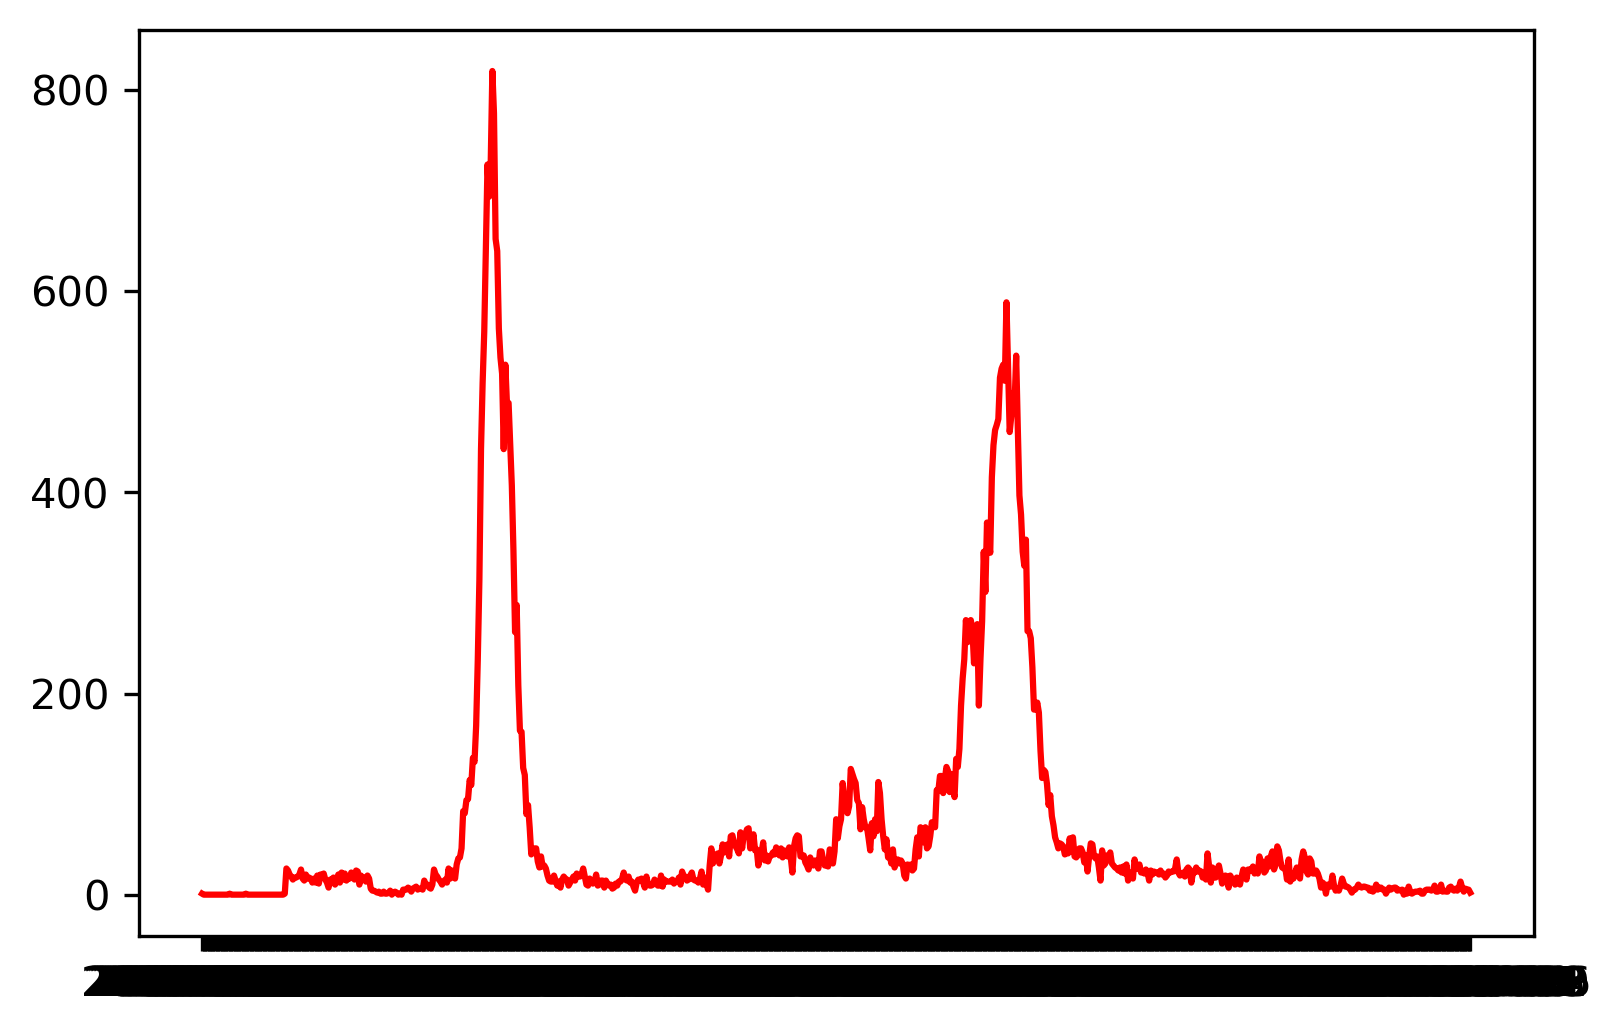

In [17]:
df_dengue_city_week = df_dengue_city_week
df_sm = df_dengue_city_week[df_dengue_city_week["COD_MUNICIPIO"]=="05001"]
fig = plt.figure(dpi=300)
plt.plot(df_sm.index,df_sm["DENGUE"], color = "red")